In [14]:
from IPython.display import Image
import numpy as np
import math

%pylab
%matplotlib inline

Using matplotlib backend: Qt4Agg
Populating the interactive namespace from numpy and matplotlib


# Сравнение S4G и 2MASS массовых моделей

Идея в том, чтобы сравнить полные массы галактик из S4G и из 2MASS фотометрии, чтобы понять, почему диски так недооцениваются.

Данные из https://irsa.ipac.caltech.edu/cgi-bin/Gator/nph-dd?catalog=s4gcat и https://ned.ipac.caltech.edu/forms/gmd.html

In [15]:
sun_abs_mags = {'U' : 5.61,
                'B' : 5.48,
                'V' : 4.83,
                'R' : 4.42,
                'I' : 4.08,
                'J' : 3.64,
                'H' : 3.32,
                'K' : 3.28,
                '3.6' : 3.24, # Oh et al. 2008
                'u' : 6.77, #SDSS bands from http://mips.as.arizona.edu/~cnaw/sun.html
                'g' : 5.36,
                'r' : 4.67,
                'i' : 4.48,
                'z' : 4.42
               }

In [16]:
s4g_rawdata = [] 

with open('IpacTableFromSource.tbl') as s4g:
    for line in s4g.readlines():
        if line[0] == '\\' or line[0] == '|':
            pass
        else:
            s4g_rawdata.append(" ".join(line.split()).split(' '))

In [17]:
print 'name    [3.6]   [4.5]   log10(stellar mass)   distance(Mpc)  std(distance)'

name    [3.6]   [4.5]   log10(stellar mass)   distance(Mpc)  std(distance)


In [18]:
s4g_rawdata[0]

['UGC00132', '-17.335', '-16.911', '9.058', 'null', 'null']

Разброс M/L по калибровке $log(M/L) = −0.339(±0.057)\times([3.6]−[4.5])−0.336(±0.002)$ https://arxiv.org/abs/1410.0009:

In [19]:
m_to_ls = []
for l in s4g_rawdata:
    if l[1] != 'null' and l[2] != 'null':
        m_to_ls.append(np.power(10, -0.339*(float(l[1]) - float(l[2])) -0.336))

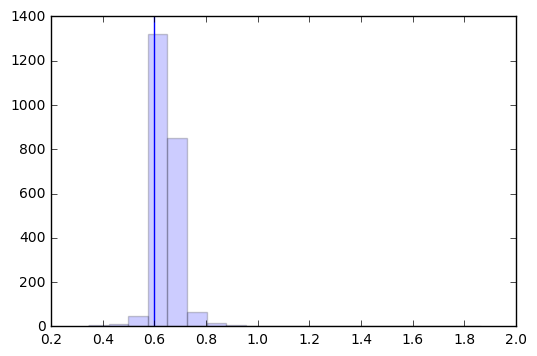

In [20]:
plt.hist(m_to_ls, bins=20, alpha=0.2)
plt.axvline(x=0.6);

Разброс достаточно маленький.

In [21]:
twomass_rawdata = [] 

with open('NED_S4G_2MASS_crossdata.txt') as crossdata:
    for line in crossdata.readlines():
            twomass_rawdata.append(" ".join(line.split()).split('|'))

In [22]:
twomass_rawdata[0]

['1 ',
 ' ',
 'PGC041965 ',
 ' ',
 'UGCA 289 ',
 '12h35m37.52s',
 '-07d52m40.1s',
 'G ',
 ' 0.003269',
 ' ',
 ' 12.832',
 ' 0.058',
 ' 1.17E-28',
 ' 6.43E-30',
 ' 12.453',
 ' 0.103',
 ' 1.07E-28',
 ' 1.06E-29',
 ' 12.235',
 ' 0.149',
 ' 8.51E-29',
 ' 1.25E-29',
 '1']

In [23]:
print 'Name         J         H      K_s'
print twomass_rawdata[0][2], twomass_rawdata[0][10], twomass_rawdata[0][14], twomass_rawdata[0][18]

Name         J         H      K_s
PGC041965   12.832  12.453  12.235


In [24]:
print s4g_rawdata[522]
print '{:2.2E}'.format(np.power(10., float(s4g_rawdata[522][3])))

['NGC4544', '-19.036', '-18.634', '9.721', '21.233', '0.824']
5.26E+09


In [25]:
for ind, l in enumerate(twomass_rawdata):
    if l[2] == 'NGC4544 ':
        print ind
        print l

699
['19 ', ' ', 'NGC4544 ', ' ', 'NGC 4544 ', '12h35m36.57s', '+03d02m04.3s', 'G ', ' 0.003849', ' ', ' 11.140', ' 0.028', ' 5.57E-28', ' 1.46E-29', ' 10.416', ' 0.030', ' 6.98E-28', ' 1.96E-29', ' 10.110', ' 0.045', ' 6.03E-28', ' 2.55E-29', '19']


In [26]:
M = float(twomass_rawdata[699][14]) - 5*np.log10(float(s4g_rawdata[522][4])) + 5 - 30.
m_to_l = 1.0
print '{:2.2E}'.format(m_to_l*np.power(10., 0.4*(sun_abs_mags['H'] - M)))

6.54E+09


In [27]:
s4g_dict = {}
for l in s4g_rawdata:
    if l[3] != 'null' and l[4] != 'null' and l[5] != 'null':
        s4g_dict[l[0]+' '] = (float(l[3]), float(l[4]), float(l[5]))

In [28]:
final = []
for gal in twomass_rawdata:
    if gal[2] in s4g_dict.keys() and gal[10] != ' ' and gal[14] != ' ' and gal[18] != ' ':
        log_stellar, dist, err_dist = s4g_dict[gal[2]]
        stellar_mass_s4g = np.power(10., log_stellar)
        magJ, magH, magK = float(gal[10]), float(gal[14]), float(gal[18])
        photom = []
        for m_to_l, mag, band in zip([1.2, 1., 0.8], [magJ, magH, magK], ['J','H','K']):
            M = mag - 5*np.log10(dist) - 30. + 5.
            twomass_stellar = m_to_l*np.power(10., 0.4*(sun_abs_mags[band] - M))
            photom.append(twomass_stellar)
        final.append((gal[2], stellar_mass_s4g, photom))

In [29]:
len(final)

898

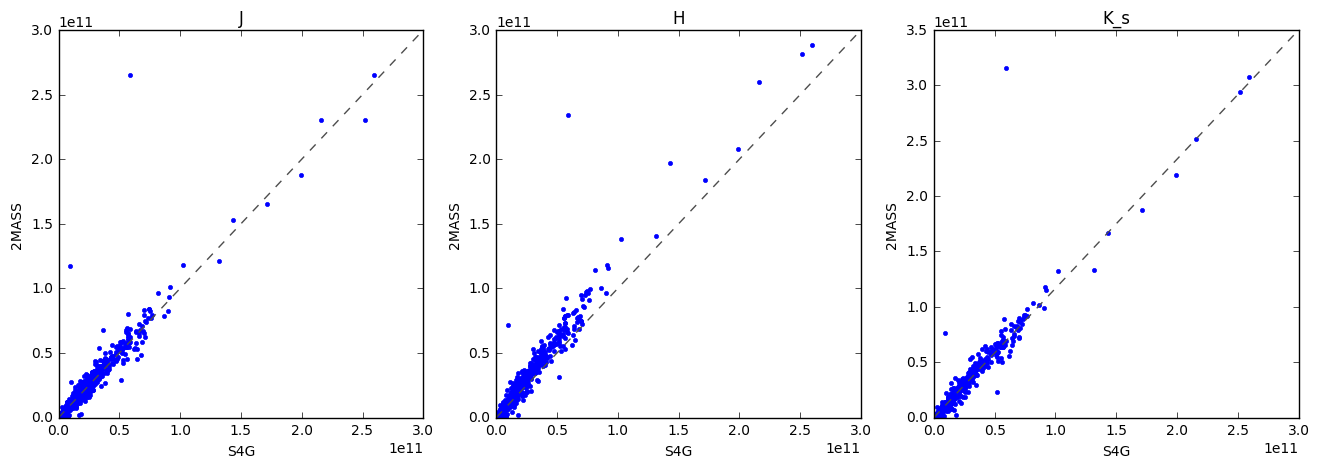

In [30]:
fig = plt.figure(figsize = [16, 5])
ax = plt.subplot('131')
ax.plot([l[1] for l in final], [l[2][0] for l in final], '.')
ax.set_title('J')
ax.set_xlabel('S4G')
ax.set_ylabel('2MASS')
ax.plot(ax.get_xlim(), ax.get_ylim(), ls="--", c=".3")

ax = plt.subplot('132')
ax.plot([l[1] for l in final], [l[2][1] for l in final], '.')
ax.set_title('H')
ax.set_xlabel('S4G')
ax.set_ylabel('2MASS')
ax.plot(ax.get_xlim(), ax.get_ylim(), ls="--", c=".3")

ax = plt.subplot('133')
ax.plot([l[1] for l in final], [l[2][2] for l in final], '.')
ax.set_title('K_s')
ax.set_xlabel('S4G')
ax.set_ylabel('2MASS')
ax.plot(ax.get_xlim(), ax.get_ylim(), ls="--", c=".3")

plt.show()

Как видим, все замечательно согласуется.

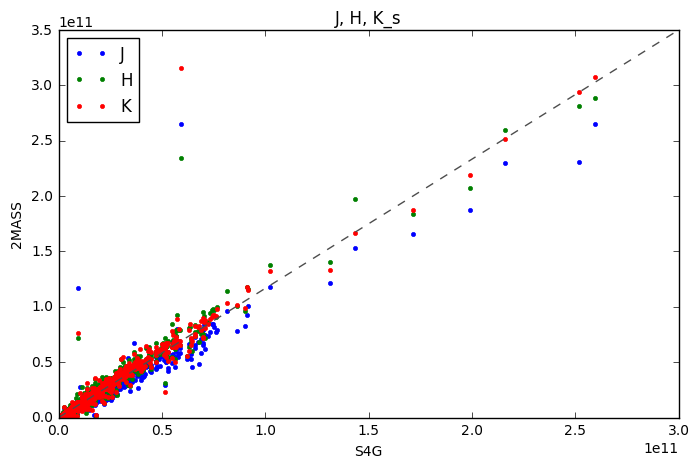

In [31]:
fig = plt.figure(figsize = [8, 5])
ax = plt.subplot()
ax.plot([l[1] for l in final], [l[2][0] for l in final], '.', label='J')

ax = plt.subplot()
ax.plot([l[1] for l in final], [l[2][1] for l in final], '.', label='H')

ax = plt.subplot()
ax.plot([l[1] for l in final], [l[2][2] for l in final], '.', label='K')
ax.set_title('J, H, K_s')
ax.set_xlabel('S4G')
ax.set_ylabel('2MASS')
ax.plot(ax.get_xlim(), ax.get_ylim(), ls="--", c=".3")
plt.legend(loc='best')
plt.show()

In [32]:
for l in final:
    if l[0] in ['NGC2985 ', 'NGC4725 ', 'NGC4258 ']:
        print l

In [33]:
for ind, l in enumerate(twomass_rawdata):
    if l[2] in ['NGC2985 ', 'NGC4725 ', 'NGC4258 ']:
        print ind
        print l

311
['224', ' ', 'NGC4258 ', ' ', 'MESSIER 106 ', '12h18m57.50s', '+47d18m14.3s', 'G ', ' 0.001494', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', '224']
389
['9 ', ' ', 'NGC4725 ', ' ', 'NGC 4725 ', '12h50m26.58s', '+25d30m02.9s', 'G ', ' 0.004023', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', '9']
1738
['159', ' ', 'NGC2985 ', ' ', 'NGC 2985 ', '09h50m22.23s', '+72d16m43.1s', 'G ', ' 0.004410', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', '159']


Что насчет полной массы из калибровок, как она согласуется с табличной?

https://irsa.ipac.caltech.edu/cgi-bin/2MASS/PubGalPS/nph-galps?locstr=147.592417+72.278967+eq&radius=5

In [34]:
for ind, l in enumerate(s4g_rawdata):
    if l[0] in ['NGC2985', 'NGC4725', 'NGC4258']:
        print ind
        print l

1692
['NGC4258', '-21.328', '-20.881', '10.672', '7.444', '0.831']
1829
['NGC2985', '-21.746', '-21.276', '10.856', '21.500', '1.273']
2006
['NGC4725', '-21.762', '-21.267', '10.881', '13.637', '2.778']


In [35]:
print s4g_rawdata[1829]
print '{:2.2E}'.format(np.power(10., float(s4g_rawdata[1829][3])))

['NGC2985', '-21.746', '-21.276', '10.856', '21.500', '1.273']
7.18E+10


* j_m_ext	8.307
* h_m_ext	7.493
* k_m_ext	7.360

In [36]:
M = 7.493 - 5*np.log10(float(s4g_rawdata[1829][4])) + 5 - 30.
m_to_l = 1.0
print '{:2.2E}'.format(m_to_l*np.power(10., 0.4*(sun_abs_mags['H'] - M)))

9.90E+10


In [37]:
M = 8.307 - 5*np.log10(float(s4g_rawdata[1829][4])) + 5 - 30.
m_to_l = 1.2
print '{:2.2E}'.format(m_to_l*np.power(10., 0.4*(sun_abs_mags['J'] - M)))

7.54E+10


In [38]:
M = 7.360 - 5*np.log10(float(s4g_rawdata[1829][4])) + 5 - 30.
m_to_l = 0.8
print '{:2.2E}'.format(m_to_l*np.power(10., 0.4*(sun_abs_mags['K'] - M)))

8.63E+10


In [39]:
final_s4g = []
for l in s4g_rawdata:
    if l[1] != 'null' and l[2] != 'null' and l[3] != 'null':
        stellar_mass_s4g = np.power(10., float(l[3]))
        
        m_to_l = np.power(10, -0.339*(float(l[1]) - float(l[2])) -0.336)
        photom_stellar = m_to_l*np.power(10., 0.4*(sun_abs_mags['3.6'] - float(l[1])))
        final_s4g.append((l[0], stellar_mass_s4g, photom_stellar))

In [40]:
len(final_s4g)

2328

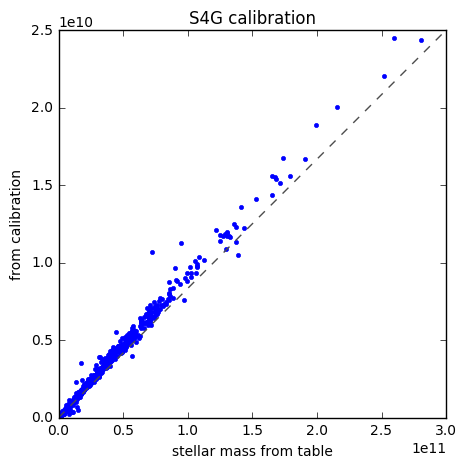

In [43]:
fig = plt.figure(figsize = [5, 5])
ax = plt.subplot()
ax.plot(zip(*final_s4g)[1], zip(*final_s4g)[2], '.')

ax.set_title('S4G calibration')
ax.set_xlabel('stellar mass from table')
ax.set_ylabel('from calibration')
ax.plot(ax.get_xlim(), ax.get_ylim(), ls="--", c=".3")
plt.show()

Хорошо согласуется.

In [42]:
for l in final_s4g:
    if l[0] in ['NGC2985', 'NGC4725', 'NGC4258']:
        print l

('NGC4258', 46989410860.521606, 4392714726.0054045)
('NGC2985', 71779429127.136154, 6572490998.7841606)
('NGC4725', 76032627694.018219, 6801504660.8040466)
